**Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
import numpy as np
import tensorflow as tf
import keras
from keras import *
from tensorflow.keras.optimizers import Adam
from keras.layers import *
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Load the dataset**

In [ ]:
def load_data():
  dataset_dir=pathlib.Path('drive/MyDrive/ML/HW3/Flowers')

  img_height=128
  img_width=128
  batch_size=32

  datagen = ImageDataGenerator(
      rescale = 1. / 255,\
      rotation_range=10,\
      horizontal_flip=True,\
      vertical_flip=False)

  img_generator = datagen.flow_from_directory(
      directory=dataset_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      shuffle=True,
  )

  X_arr=[]
  i=0
  img=img_generator.next()
  while(i < img_generator.n):
    for j in range(0,32):
      if(i+j < img_generator.n):
        X_arr.append(img[0][j])
        i=i+1

  X_train = np.asarray(X_arr)
  return X_train


X_train=load_data()

Found 888 images belonging to 1 classes.


**Visualize examples**

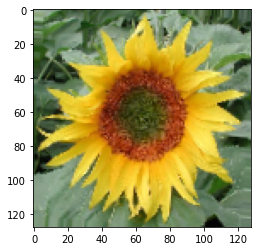

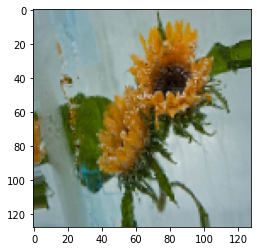

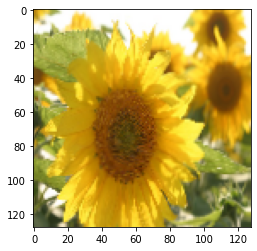

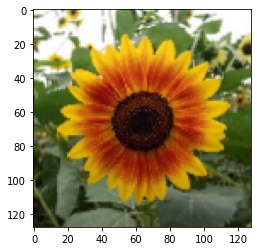

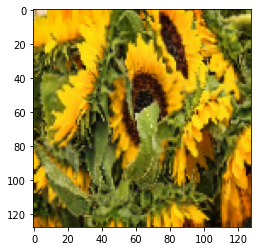

In [ ]:
n = 5

for i in range(0,n):
    image = X_train[i]
    plt.imshow(image)
    plt.show()

**Define the GAN model**

In [ ]:
class GAN():
 
    def __init__(self, latent_dim=128):

        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
 
        optimizer = Adam(lr=0.0002, beta_1=0.5)
 
        disc_fn = self.build_discriminator_CNN
        gen_fn = self.build_generator_CNN

        # Build and compile the discriminator
        self.discriminator = disc_fn()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer, metrics=['accuracy'])

        self.latent_dim = latent_dim

        self.Goutact = 'sigmoid'   

        # Build and compile the generator
        self.generator = gen_fn()
  
        self.discriminator.trainable = False
 
        # The combined model  
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.combined.summary()
 
        # plot the models
        plot_model(self.discriminator, to_file='drive/MyDrive/ML/HW3/plots/D.png', show_shapes=True, show_layer_names=True)
        plot_model(self.generator, to_file='drive/MyDrive/ML/HW3/plots/G.png', show_shapes=True, show_layer_names=True)
        plot_model(self.combined, to_file='drive/MyDrive/ML/HW3/plots/GAN.png', show_shapes=True, show_layer_names=True)

        # Load the dataset
        self.X_train = load_data()

        # Training epochs
        self.epoch = 0


    def build_generator_CNN(self):

        noise_shape = (self.latent_dim,)

        model = Sequential()
        # foundation for 32x32 image
        n_nodes = 128 * 32 * 32
        model.add(Dense(n_nodes, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((32, 32, 128)))
        # upsample to 64x64
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 128x128
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, (32,32), activation='sigmoid', padding='same'))

        model.summary()

        return model

    def build_discriminator_CNN(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()
        model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(96, (3,3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        return model


    def train(self, epochs, batch_size=128, save_interval=100, show_img=False):

        half_batch = int(batch_size / 2)
 
        last_epoch = self.epoch + epochs

        self.save_imgs(self.epoch)
        self.d_loss = []
        self.g_loss = []

        while self.epoch < last_epoch:

            #  Train Discriminator
            #real=1 fake=0

            idx = np.random.randint(0, self.X_train.shape[0], half_batch)
            imgs = self.X_train[idx]
            y_imgs = np.ones((half_batch, 1))
 
            noise = np.random.uniform(-1.0, 1.0, (half_batch, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            y_gen = np.zeros((half_batch, 1))
 
            X = np.vstack((imgs, gen_imgs))
            y = np.vstack((y_imgs, y_gen))
            d_loss = self.discriminator.train_on_batch(X, y)
            
            self.d_loss.append(d_loss[0])
 
            #  Train Generator
            noise = np.random.uniform(-1.0, 1.0, (batch_size, self.latent_dim))
 
            y_gennoise = np.ones((batch_size, 1))
 
            g_loss = self.combined.train_on_batch(noise, y_gennoise)
            self.g_loss.append(g_loss)
 
            self.epoch += 1

            if self.epoch % save_interval == 0:
                # Show progress                
                print ( "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (self.epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.save_imgs(self.epoch,show_img=False)
                if(str(self.epoch)[-3] == '5' or str(self.epoch - 500)[-3]=='5'):
                  self.save_imgs(self.epoch,show_img=True)
                  self.show_plot(self.epoch-500,self.epoch)
                


    def gen_imgs(self):
        cc = 9
        noise = np.random.uniform(-1.0, 1.0, (cc, self.latent_dim))
        self.imgs = self.generator.predict(noise)


    def save_imgs(self, epoch, show_img=False):
        r, c = 3, 3
        self.gen_imgs()

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                self.img=self.imgs[cnt,:,:,:]
                self.img=np.reshape(self.img,[128,128,3])
                axs[i,j].imshow(self.img)
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("drive/MyDrive/ML/HW3/Generated_flow/img_%05d.png" %(epoch))
        if show_img:
            plt.show()
        plt.close()


    def show_images(self):
        r, c = 3, 3
        self.gen_imgs()
 
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                self.img=self.imgs[cnt,:,:,:]
                self.img=np.reshape(self.img,[128,128,3])
                axs[i,j].imshow(self.img)
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()


    def save_model(self):
      filename = 'drive/MyDrive/ML/HW3/Models/Flow/G_model_%05d.h5' %(self.epoch)
      self.generator.save(filename)
      filename = 'drive/MyDrive/ML/HW3/Models/Flow/D_model_%05d.h5' %(self.epoch)
      self.discriminator.save(filename)
      print("Models G/%s saved." %(filename))

    def show_plot(self, start, end):
      plt.subplots()
      plt.xlim(start,end)
      plt.plot(self.d_loss, label='D loss')
      plt.plot(self.g_loss, label='G loss')
      plt.show()
      plt.close()

    def load_model(self,epoch):
      optimizer = Adam(lr=0.0002, beta_1=0.5)
      self.epoch = epoch
      filename = 'drive/MyDrive/ML/HW3/Models/Flow/G_model_%05d.h5' %(self.epoch)
      self.generator= tf.keras.models.load_model(filename)
      filename = 'drive/MyDrive/ML/HW3/Models/Flow/D_model_%05d.h5' %(self.epoch)
      self.discriminator= tf.keras.models.load_model(filename)
      self.discriminator.trainable = False

      self.combined = Sequential()
      self.combined.add(self.generator)
      self.combined.add(self.discriminator)
      self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
      print("Models G/%s loaded." %(filename))

**Create the GAN**

In [ ]:
gan = GAN(latent_dim=256)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        55392     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       1

**train and save the GAN**

100 [D loss: 0.593339, acc.: 78.12%] [G loss: 0.939779]
200 [D loss: 0.687646, acc.: 56.25%] [G loss: 0.594424]
300 [D loss: 0.655217, acc.: 65.62%] [G loss: 0.734903]
400 [D loss: 0.671845, acc.: 62.50%] [G loss: 0.806798]
500 [D loss: 0.662684, acc.: 68.75%] [G loss: 0.793724]


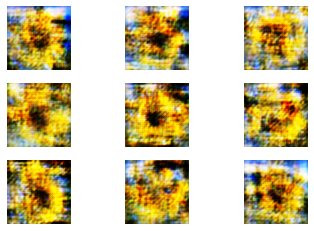

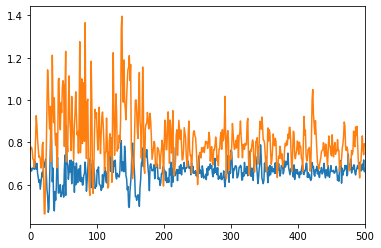

600 [D loss: 0.666290, acc.: 65.62%] [G loss: 0.800253]
700 [D loss: 0.661372, acc.: 62.50%] [G loss: 0.664117]
800 [D loss: 0.676708, acc.: 56.25%] [G loss: 0.658084]
900 [D loss: 0.669200, acc.: 65.62%] [G loss: 0.871760]
1000 [D loss: 0.706926, acc.: 40.62%] [G loss: 0.706588]


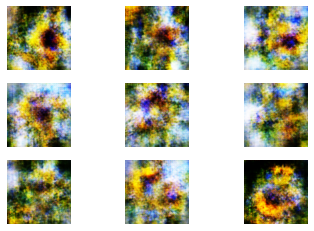

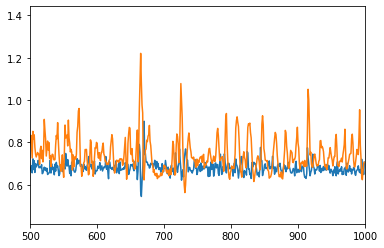

1100 [D loss: 0.653866, acc.: 65.62%] [G loss: 0.654693]
1200 [D loss: 0.609973, acc.: 65.62%] [G loss: 0.808022]
1300 [D loss: 0.537989, acc.: 87.50%] [G loss: 0.849723]
1400 [D loss: 0.582695, acc.: 62.50%] [G loss: 1.075909]
1500 [D loss: 0.493045, acc.: 84.38%] [G loss: 1.616002]


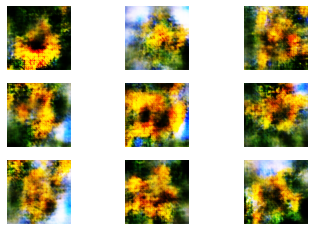

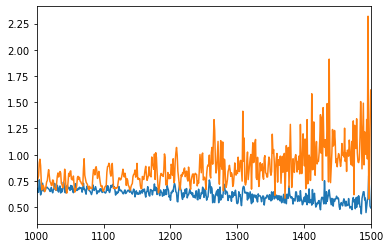

1600 [D loss: 0.508033, acc.: 84.38%] [G loss: 1.099325]
1700 [D loss: 0.395507, acc.: 90.62%] [G loss: 1.356238]
1800 [D loss: 0.446442, acc.: 87.50%] [G loss: 0.833614]
1900 [D loss: 0.463671, acc.: 90.62%] [G loss: 1.491855]
2000 [D loss: 0.626399, acc.: 62.50%] [G loss: 0.802204]


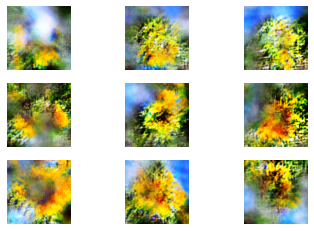

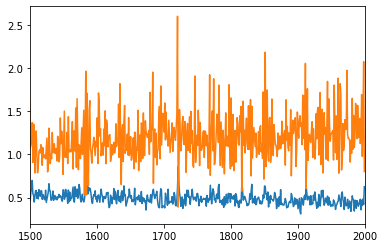

2100 [D loss: 0.359211, acc.: 87.50%] [G loss: 1.248955]
2200 [D loss: 0.485521, acc.: 81.25%] [G loss: 1.567442]
2300 [D loss: 0.312244, acc.: 93.75%] [G loss: 1.396780]
2400 [D loss: 0.327104, acc.: 90.62%] [G loss: 1.502002]
2500 [D loss: 0.297909, acc.: 93.75%] [G loss: 1.835264]


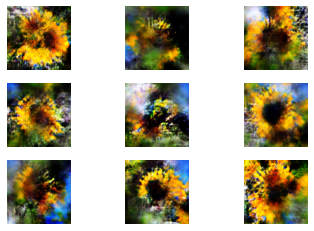

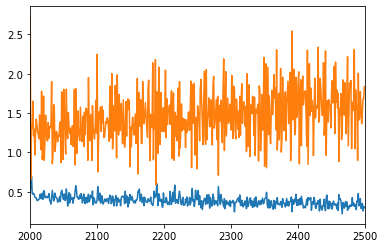

2600 [D loss: 0.371548, acc.: 90.62%] [G loss: 1.892726]
2700 [D loss: 0.299592, acc.: 93.75%] [G loss: 1.785983]
2800 [D loss: 0.285542, acc.: 96.88%] [G loss: 1.125553]
2900 [D loss: 0.231237, acc.: 100.00%] [G loss: 1.521126]
3000 [D loss: 0.391072, acc.: 81.25%] [G loss: 1.815001]


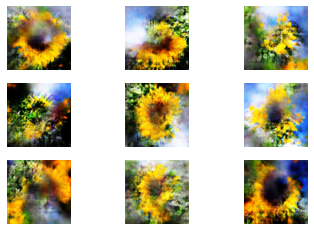

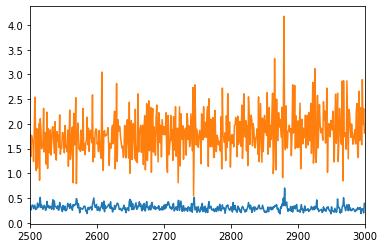

3100 [D loss: 0.278299, acc.: 90.62%] [G loss: 1.473409]
3200 [D loss: 0.215816, acc.: 93.75%] [G loss: 2.457927]
3300 [D loss: 0.235855, acc.: 93.75%] [G loss: 2.673507]
3400 [D loss: 0.310495, acc.: 90.62%] [G loss: 2.357714]
3500 [D loss: 0.192243, acc.: 96.88%] [G loss: 1.786014]


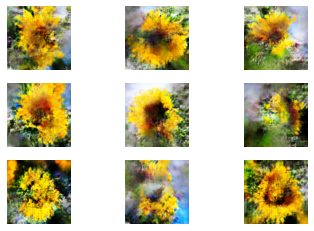

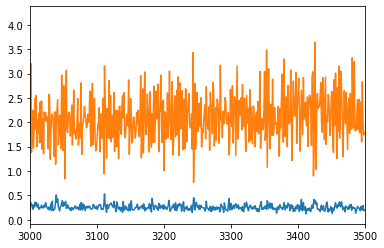

3600 [D loss: 0.182964, acc.: 90.62%] [G loss: 2.964166]
3700 [D loss: 0.244137, acc.: 87.50%] [G loss: 2.688001]
3800 [D loss: 0.320050, acc.: 87.50%] [G loss: 2.245725]
3900 [D loss: 0.189725, acc.: 90.62%] [G loss: 2.009247]
4000 [D loss: 0.252498, acc.: 93.75%] [G loss: 3.988798]


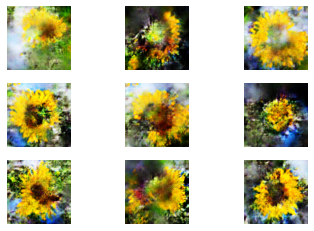

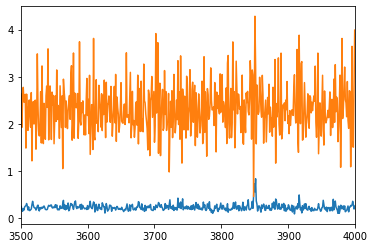

4100 [D loss: 0.213070, acc.: 93.75%] [G loss: 2.395492]
4200 [D loss: 0.222155, acc.: 96.88%] [G loss: 3.100419]
4300 [D loss: 0.145936, acc.: 96.88%] [G loss: 2.959972]
4400 [D loss: 0.182895, acc.: 93.75%] [G loss: 2.296470]
4500 [D loss: 0.112149, acc.: 100.00%] [G loss: 1.970907]


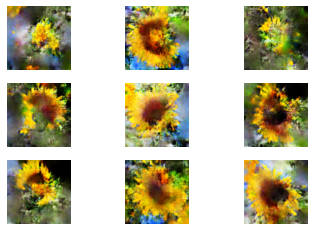

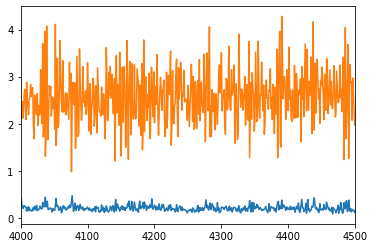

4600 [D loss: 0.179671, acc.: 96.88%] [G loss: 3.151153]
4700 [D loss: 0.184874, acc.: 93.75%] [G loss: 1.925720]
4800 [D loss: 0.133513, acc.: 96.88%] [G loss: 3.369587]
4900 [D loss: 0.249383, acc.: 90.62%] [G loss: 3.623982]
5000 [D loss: 0.145908, acc.: 93.75%] [G loss: 2.547900]


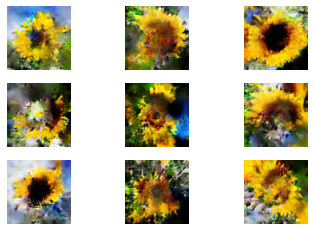

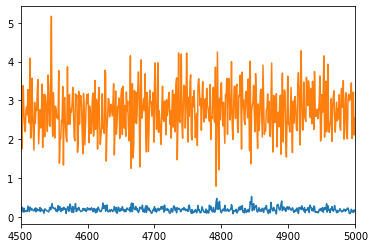

5100 [D loss: 0.183628, acc.: 96.88%] [G loss: 3.702180]
5200 [D loss: 0.084409, acc.: 100.00%] [G loss: 3.311316]
5300 [D loss: 0.196273, acc.: 93.75%] [G loss: 2.623142]
5400 [D loss: 0.074038, acc.: 100.00%] [G loss: 3.354356]
5500 [D loss: 0.173617, acc.: 96.88%] [G loss: 2.359460]


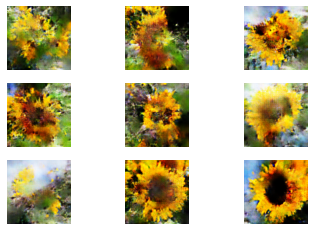

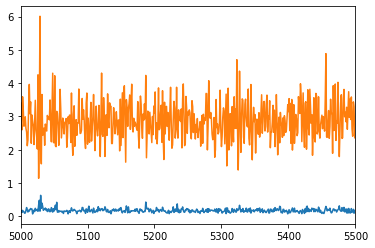

5600 [D loss: 0.149629, acc.: 100.00%] [G loss: 3.861765]
5700 [D loss: 0.173885, acc.: 96.88%] [G loss: 4.783869]
5800 [D loss: 0.148248, acc.: 90.62%] [G loss: 3.119049]
5900 [D loss: 0.186987, acc.: 93.75%] [G loss: 4.043900]
6000 [D loss: 0.210639, acc.: 90.62%] [G loss: 2.908851]


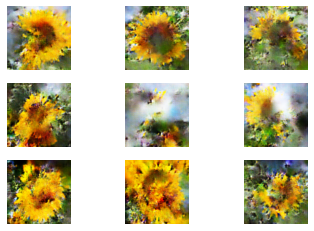

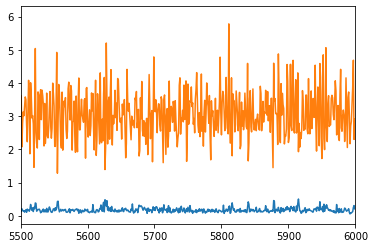

6100 [D loss: 0.181735, acc.: 96.88%] [G loss: 3.908080]
6200 [D loss: 0.132699, acc.: 96.88%] [G loss: 3.365541]
6300 [D loss: 0.189494, acc.: 90.62%] [G loss: 2.756625]
6400 [D loss: 0.267331, acc.: 87.50%] [G loss: 3.234495]
6500 [D loss: 0.165995, acc.: 90.62%] [G loss: 2.871470]


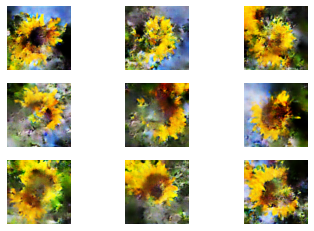

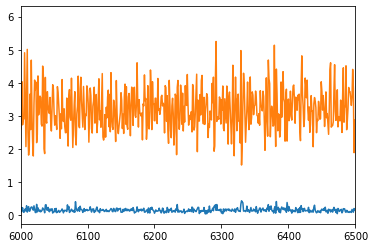

6600 [D loss: 0.180153, acc.: 93.75%] [G loss: 3.303946]
6700 [D loss: 0.109968, acc.: 96.88%] [G loss: 3.162991]
6800 [D loss: 0.178512, acc.: 93.75%] [G loss: 3.442103]
6900 [D loss: 0.123844, acc.: 93.75%] [G loss: 3.649421]
7000 [D loss: 0.150262, acc.: 93.75%] [G loss: 2.486486]


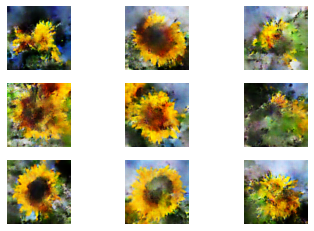

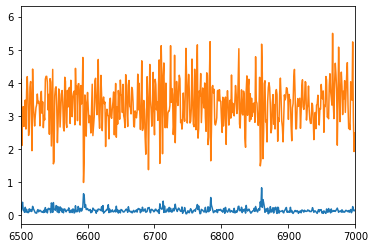

7100 [D loss: 0.095170, acc.: 100.00%] [G loss: 2.031165]
7200 [D loss: 0.089258, acc.: 96.88%] [G loss: 2.183077]
7300 [D loss: 0.079307, acc.: 96.88%] [G loss: 3.006090]
7400 [D loss: 0.140947, acc.: 93.75%] [G loss: 3.650796]
7500 [D loss: 0.104938, acc.: 96.88%] [G loss: 3.444964]


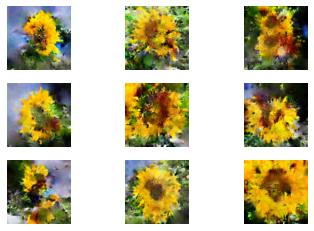

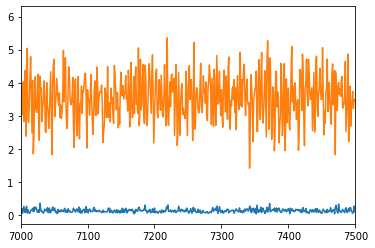

7600 [D loss: 0.202165, acc.: 93.75%] [G loss: 3.494262]
7700 [D loss: 0.146147, acc.: 96.88%] [G loss: 2.673486]
7800 [D loss: 0.178837, acc.: 84.38%] [G loss: 2.913317]
7900 [D loss: 0.119751, acc.: 96.88%] [G loss: 3.893178]
8000 [D loss: 0.217335, acc.: 84.38%] [G loss: 3.015670]


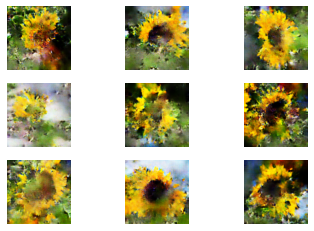

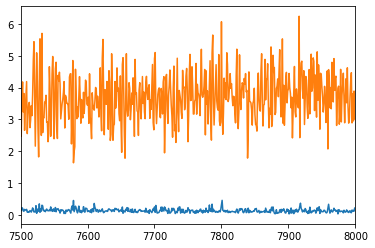

8100 [D loss: 0.131108, acc.: 96.88%] [G loss: 3.225590]
8200 [D loss: 0.173334, acc.: 93.75%] [G loss: 3.678722]
8300 [D loss: 0.077878, acc.: 96.88%] [G loss: 2.569542]
8400 [D loss: 0.118977, acc.: 96.88%] [G loss: 3.338099]
8500 [D loss: 0.086696, acc.: 100.00%] [G loss: 3.097729]


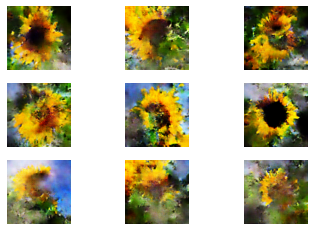

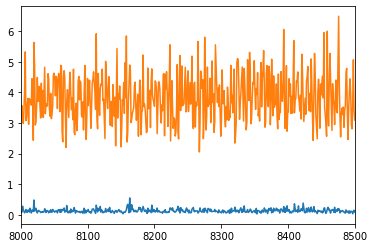

8600 [D loss: 0.552024, acc.: 81.25%] [G loss: 1.310995]
8700 [D loss: 0.139637, acc.: 93.75%] [G loss: 5.122821]
8800 [D loss: 0.076547, acc.: 96.88%] [G loss: 3.388753]
8900 [D loss: 0.174000, acc.: 93.75%] [G loss: 3.359405]
9000 [D loss: 0.063296, acc.: 100.00%] [G loss: 2.960009]


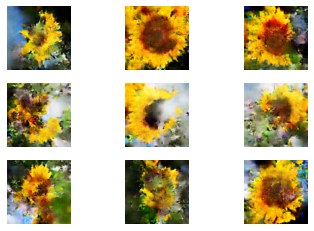

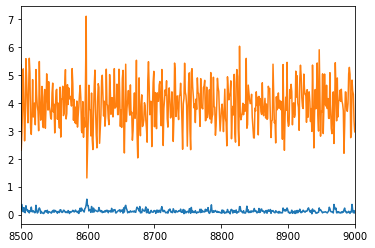

9100 [D loss: 0.198200, acc.: 90.62%] [G loss: 4.267136]
9200 [D loss: 0.128224, acc.: 90.62%] [G loss: 4.535208]
9300 [D loss: 0.214815, acc.: 93.75%] [G loss: 3.387478]
9400 [D loss: 0.110838, acc.: 93.75%] [G loss: 3.470337]
9500 [D loss: 0.094021, acc.: 96.88%] [G loss: 3.991346]


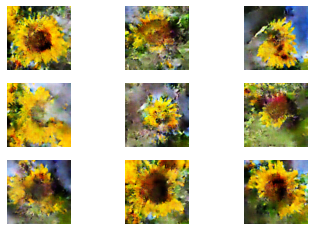

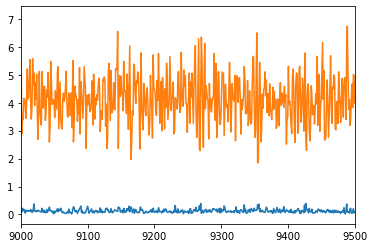

9600 [D loss: 0.179725, acc.: 90.62%] [G loss: 5.333125]
9700 [D loss: 0.112079, acc.: 93.75%] [G loss: 4.360294]
9800 [D loss: 0.107662, acc.: 96.88%] [G loss: 4.306013]
9900 [D loss: 0.109393, acc.: 93.75%] [G loss: 3.631391]
10000 [D loss: 0.060188, acc.: 96.88%] [G loss: 4.403919]


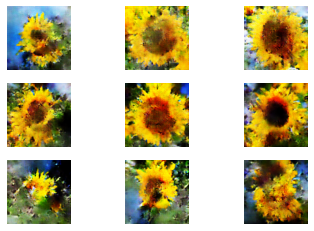

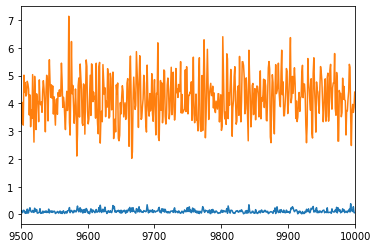

Models G/drive/MyDrive/ML/HW3/Models/Flow/D_model_10000.h5 saved.


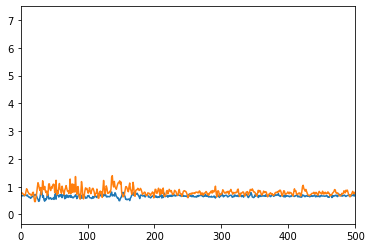

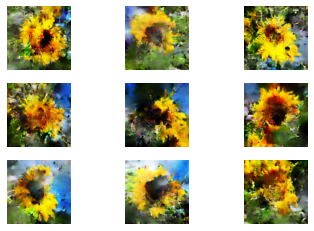

In [ ]:
gan.train(epochs=10000, batch_size=32, save_interval=100)
gan.save_model()
plt.subplots()
plt.xlim(0,500)
plt.plot(gan.d_loss, label='D loss')
plt.plot(gan.g_loss, label='G loss')
plt.show()
plt.close()
gan.show_images()

**Plot losses**

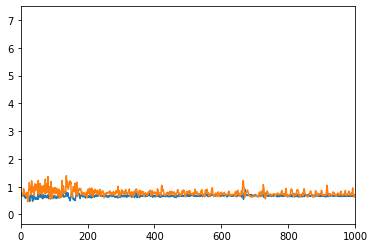

In [ ]:
plt.subplots()
plt.xlim(0,1000)
plt.plot(gan.d_loss, label='D loss')
plt.plot(gan.g_loss, label='G loss')
plt.show()
plt.close()

**Show examples of the generated images**

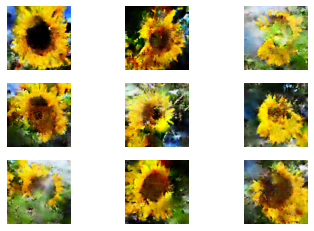

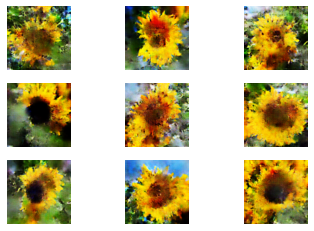

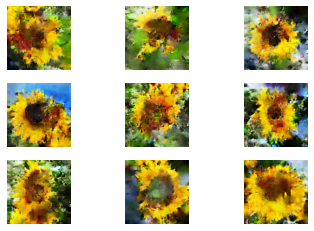

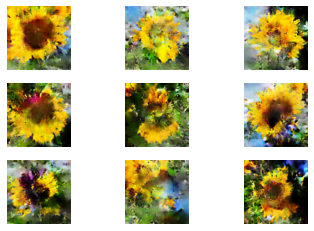

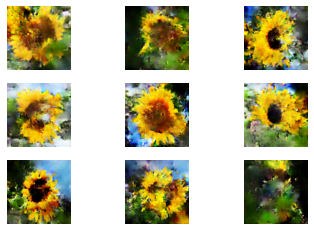

In [ ]:
i=0
while(i<5):
  gan.show_images()
  i=i+1

**Save the model**

In [ ]:
gan.save_model()

Models G/drive/MyDrive/ML/HW3/Models/Flow/D_model_10000.h5 saved.
